In [1]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Reshape, concatenate, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tqdm.notebook import tqdm
import warnings
import matplotlib.pyplot as plt
tqdm.pandas()

2025-08-24 16:07:30.748867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756051650.771778     124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756051650.779784     124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
with open('/kaggle/input/flickr8k-prepared-data/tokenizer.pkl', "rb") as f:
    tokenizer = pickle.load(f)

# Check the loaded tokenizer
print("tokenizer loaded successfully")

tokenizer loaded successfully


In [3]:
with open('/kaggle/input/flickr8k-prepared-data/features.pkl', "rb") as f:
    features = pickle.load(f)

# Check the loaded features
print("Features loaded successfully")

Features loaded successfully


In [4]:
data = pd.read_pickle('/kaggle/input/flickr8k-prepared-data/captions.pkl') # contains cleaned and wrapped captions

# Check the loaded features
print("captions dataframe loaded successfully")

captions dataframe loaded successfully


In [5]:
captions = data['caption'].tolist()

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

In [6]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)

In [7]:
# Inputs
input1 = Input(shape=(2048,))          # Image features
input2 = Input(shape=(max_length,))    # Captions (tokenized sequence)

# 🔹 Image feature processing
img_features = Dense(256, activation='relu')(input1)     # (None, 256)
img_features = Dropout(0.4)(img_features)                # stronger dropout
img_features_seq = Reshape((1, 256))(img_features)       # (None, 1, 256) for sequence merge

# 🔹 Caption sequence processing
sentence_features = Embedding(vocab_size, 128, mask_zero=False)(input2)  # (None, max_length, 128)
sentence_features = Dense(256)(sentence_features)                       # project to 256D → (None, max_length, 256)

# 🔹 Merge image "token" + caption sequence
merged = concatenate([img_features_seq, sentence_features], axis=1)     # (None, max_length+1, 256)

# 🔹 LSTM for sequential modeling
lstm_out = LSTM(256, return_sequences=False)(merged)   # (None, 256)
lstm_out = Dropout(0.3)(lstm_out)                      # lighter dropout for LSTM

# 🔹 Residual connection (keep img_features flat for matching shape)
x = add([lstm_out, img_features])   # (None, 256)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)                  # stronger dropout for Dense

# 🔹 Output
output = Dense(vocab_size, activation='softmax')(x)

# 🔹 Compile model
optimizer = Adam(learning_rate=0.0005)
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=optimizer,
    metrics=['accuracy']
)

caption_model.summary()

I0000 00:00:1756051654.631376     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756051654.632032     124 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 128)   │  1,086,080 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 34, 256)   │     33,024 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8485)      │  2,180,645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,415,397 (16.84 MB)

 Trainable params: 4,415,397 (16.84 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,tokenizer=tokenizer,vocab_size=vocab_size,
                                      max_length=max_length,features=features,shuffle=True)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,tokenizer=tokenizer,vocab_size=vocab_size,
                                           max_length=max_length,features=features,shuffle=False)

In [9]:
# Save the best model based on val_loss
checkpoint = ModelCheckpoint(
    "model.keras",  # Use .keras in Keras 3.x
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

# Stop training early if val_loss doesn't improve
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Reduce learning rate if val_loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=1e-8
)

# Train the model
history = caption_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1756051661.067752     173 cuda_dnn.cc:529] Loaded cuDNN version 90300


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1286 - loss: 5.7264
Epoch 1: val_loss improved from inf to 4.30189, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 115s 206ms/step - accuracy: 0.1287 - loss: 5.7252 - val_accuracy: 0.2431 - val_loss: 4.3019 - learning_rate: 5.0000e-04
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2454 - loss: 4.2734
Epoch 2: val_loss improved from 4.30189 to 3.96005, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 108s 201ms/step - accuracy: 0.2454 - loss: 4.2732 - val_accuracy: 0.2750 - val_loss: 3.9601 - learning_rate: 5.0000e-04
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2691 - loss: 3.9340
Epoch 3: val_loss improved from 3.96005 to 3.79027, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 107s 200ms/step - accuracy: 0.2691 - loss: 3.9340 - val_accuracy: 0.2918 - val_loss: 3.7903 - learning_rate: 5.0000e-04
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy

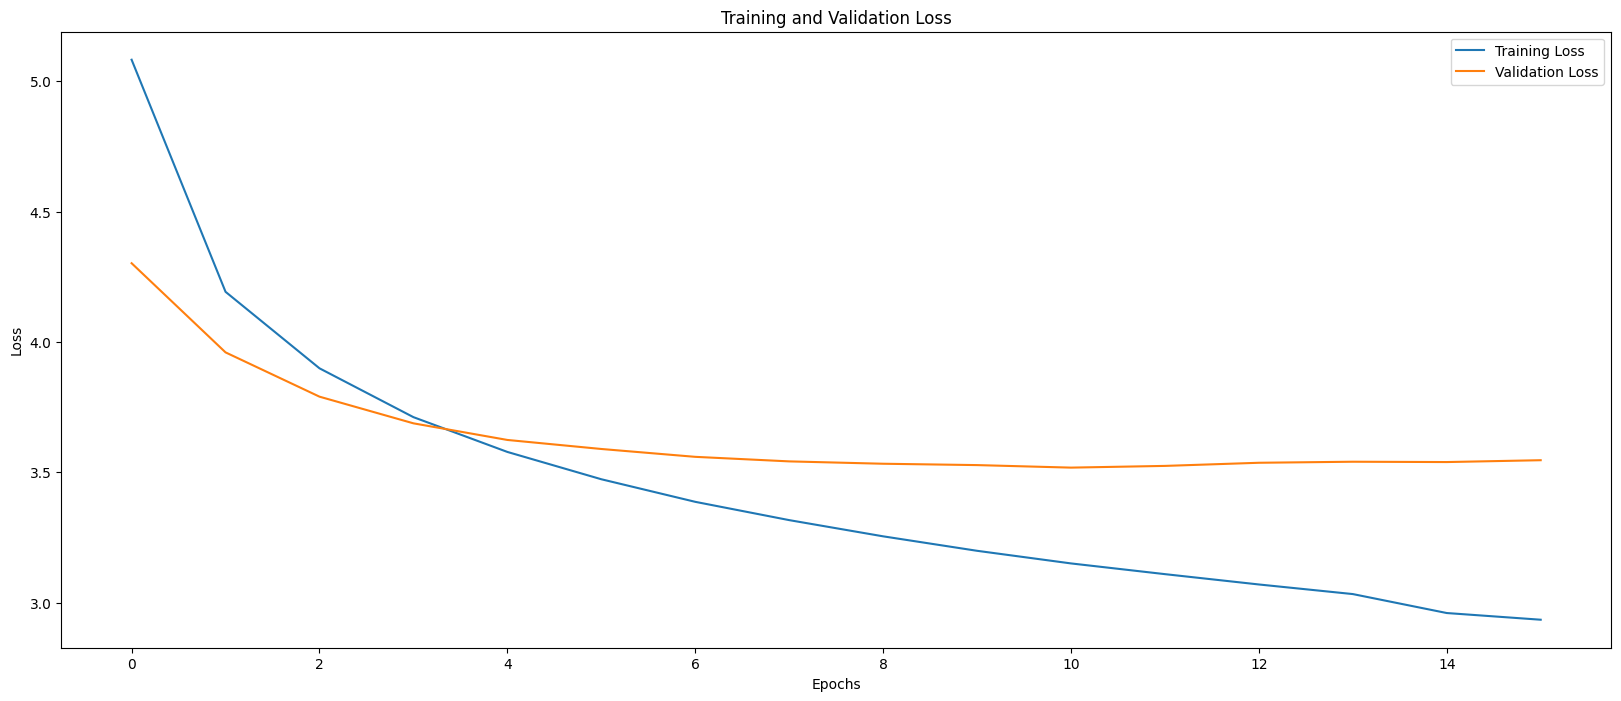

In [10]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.show()

In [11]:
with open("history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [12]:
with open("config.pkl", "wb") as f:
    pickle.dump({'max_length': max_length, 'vocab_size': vocab_size}, f)

In [13]:
caption_model.save("model.keras")

In [14]:
caption_model.save_weights("caption_model.weights.h5")

In [15]:
test.to_pickle("test.pkl")